## Laboratorium 8.2


## Przepływ optyczny i śledzenie obiektów

### Wprowadzenie

Metodę przepływu optycznego (między innymi) można stosować również do śledzenia obiektów. Zazwyczaj wykorzystuje się w tym celu metody rzadkie połączone ze znanymi już nam metodami detekcji punktów zainteresowania. Procedura przebiega podobnie jak w przypadku gęstego przepływu (tzn. operujemy na parze klatek w skali szarości, znajdujemy wektory przesunięć), z tą różnicą że obliczanie przepływu zachodzi wyłącznie dla interesujących nas punktów - a zatem musimy znać ich położenia, aby zainicjować proces. Można sobie wyobrazić różne sposoby zlokalizowania punktów kluczowych, w zależności od konkretnego zastosowania i założeń: być może np. pipeline do przetwarzania rozpoczyna się od detekcji obiektów, a może z góry wiemy, gdzie obiekty się początkowo znajdują.

W OpenCV podstawową metodą do obliczania przepływu dla zbioru punktów jest metoda Lucasa-Kanade, zaimplementowana w funkcji [`cv2.calcOpticalFlowPyrLK`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323). Podobnie jak w metodzie Farnebacka, argument `nextPts` ustawiamy na `None` (chyba, że chcemy zainicjować rozwiązanie już znanymi położeniami punktów, ale w praktyce z reguły nie będziemy mieli takiej wygody), argumenty `status` i `err` pomijamy zupełnie. W odróżnieniu od Farnebacka, wynikiem są absolutne położenia punktów na drugiej klatce (a nie wektory przesunięć). Dodatkowo otrzymujemy też wektor `status` informujący dla każdego punktu, czy udało się go odnaleźć, oraz `err` mierzący jakąś miarę błędu wizualnego pomiędzy fragmentem obrazu zawierającym dany punkt kluczowy.

Do inicjalizacji rozwiązania można wykorzystać znane nam metody znajdowania punktów kluczowych, albo opartą o detektor Harrisa funkcję [`cv2.goodFeaturesToTrack`](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga1d6bb77486c8f92d79c8793ad995d541) - jest nieco prostsza w użyciu, bo na wyjściu otrzymujemy po prostu macierz `np.float32` o wymiarach $Nx1x2$ zawierającą koordynaty znalezionych punktów.

Oczywiście, śledzenie obiektów oparte o jednorazową inicjalizację jest narażone na błędy: zniknięcie lub tymczasowe zasłonięcie śledzonego obiektu, czy choćby zmiana jego wyglądu (np. wskutek pojawienia się cienia) mogą spowodować, że przepływ nie zostanie obliczony. Może być też pożądana możliwość śledzenia ciągłego z uwzględnieniem pojawiania się nowych obiektów (np. monitorowanie CCTV). W takich sytuacjach konieczne jest regularne odświeżanie inicjalizacji, tj. ponowne wykrycie interesujących obiektów. To z kolei prowadzi do kolejnego problemu: jeżeli interesuje nas cała historia ruchu danych obiektów, przy czym do pewnego momentu ich lokalizacje uzyskiwaliśmy za pomocą przepływu optycznego, a w pewnym momencie wykonaliśmy ponowną detekcję - to jak powiązać jedno z drugim, by zapewnić ciągłość lokalizacji? To zagadnienie, oraz pozostałe tematy dyskutowane w tym kontekście na wykładzie, nie będzie jednak centralne na laboratorium.

---

### Cel zadania

Celem tej listy jest (1) zapoznanie się z metodą przepływu optycznego rzadkiego do zastosowań śledzenia obiektów, oraz (2) zastosowanie tej techniki w praktyce, na przykładzie monitorowania prędkości obiektu (w metrach na sekundę). Przykładem badawczym będzie nagranie startu Wahadłowca Kosmicznego _Discovery_ (misja [STS-124](https://en.wikipedia.org/wiki/STS-124)), zarejestrowane jedną z kamer technicznych (plik `shuttle.mp4`).

Aby obliczyć prędkość, potrzebna jest znajomość drogi (w metrach) i czasu (w sekundach). Czas między klatkami obliczysz, znając liczbę klatek na sekundę, którą możesz pobrać bezpośrednio z otwartego obiektu `VideoCapture` za pomocą następującej konstrukcji:  
```python
fps = source.get(cv2.CAP_PROP_FPS)
```  
Wyznaczenie przelicznika między przestrzenią obrazu (w pikselach) a przestrzenią świata (w metrach) jest w ogólności [nieco złożonym zagadnieniem](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html); znalezienie uproszczonej alternatywy jest Twoim zadaniem.

Źródło nagrania: [_"Best of the Best" Provides New Views, Commentary of Shuttle Launches_ (NASA @ YouTube)](https://www.youtube.com/watch?v=vFwqZ4qAUkE), 29:06.5  
Nagranie o oryginalnej prędkości ~225 fps odtwarzane przy typowej prędkości 30fps wyglądałoby na spowolnione w proporcji ok. 1:7.5; zostało zatem przekodowane tak, aby osiągnąć zbieżność upływu czasu 1:1 z rzeczywistym. Możesz się o tym upewnić patrząc na _timestamp_ z prawej strony nagrania ([_jak go czytać_](https://space.stackexchange.com/a/38569)).

In [3]:
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

### Zadanie 1

Na podstawie pierwszej klatki z materiału dokonaj kalibracji parametrów detektora cech do śledzenia (sugerowany detektor: [`cv2.goodFeaturesToTrack`](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga1d6bb77486c8f92d79c8793ad995d541)). Dobór tych parametrów jest kluczowy dla reszty zadania, więc zapoznaj się z ich znaczeniem i postaraj tak dobrać, by uzyskać odpowiednio dużo (10+) punktów w rejonie śledzonego obiektu.

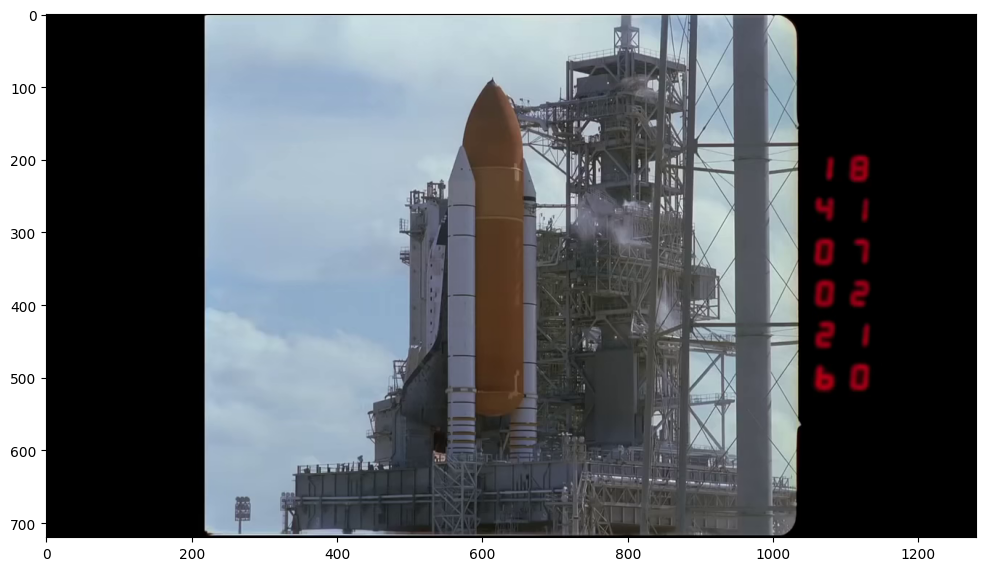

In [4]:
source = cv2.VideoCapture('dane/shuttle.mp4')
status, frame = source.read()
source.release()
plt.subplots(1, 1, figsize=(12,12))[1].imshow(frame[..., ::-1]);

C:\Users\kjani\AppData\Local\Temp\ipykernel_14912\3149970130.py:3: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)


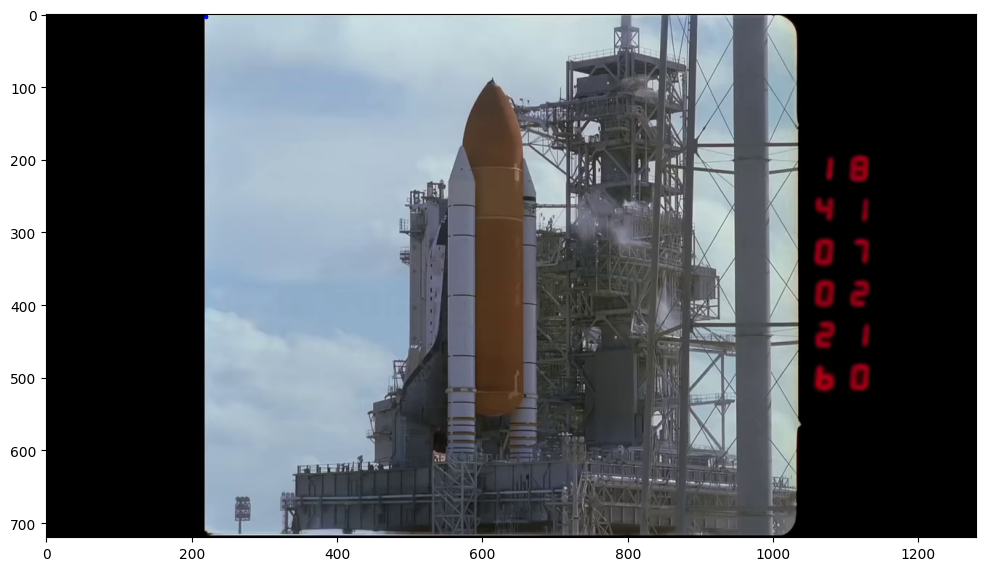

In [5]:
source_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
corners = cv2.goodFeaturesToTrack(source_gray, 100, 0.999, 7, blockSize=7)
corners = np.int0(corners)

for corner in corners:
    x, y = corner.ravel()
    cv2.circle(frame, (x, y), 3, 255, -1)

plt.subplots(1, 1, figsize=(12,12))[1].imshow(frame[..., ::-1]);

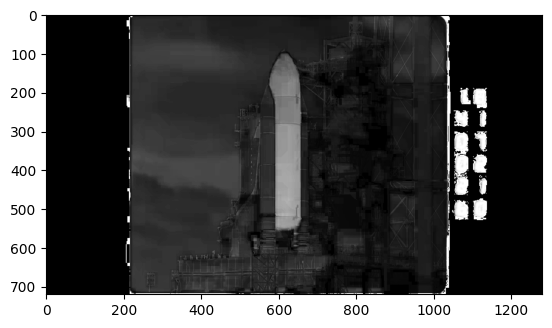

In [6]:
hsv_source = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(hsv_source)
plt.imshow(s, cmap='gray');

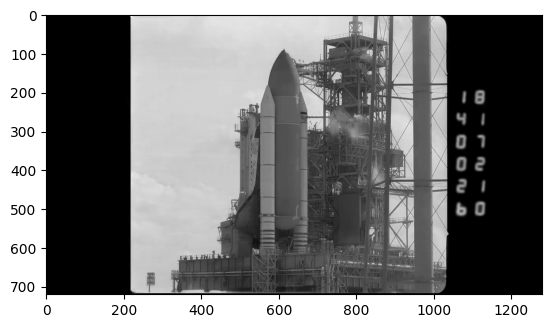

In [7]:
plt.imshow(v, cmap='gray');

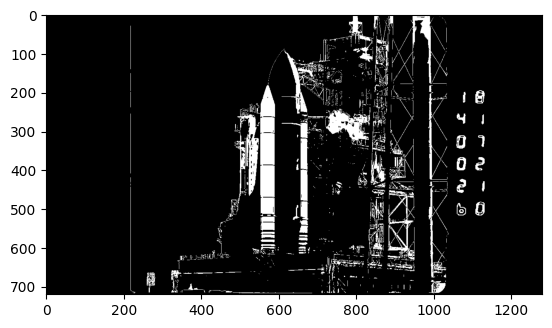

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

lower_gray = 100
upper_gray = 150

# Używamy inRange do wyodrębnienia szarych obszarów
gray_mask = cv2.inRange(v, lower_gray, upper_gray)

# Wyświetlamy wynik
plt.imshow(gray_mask, cmap='gray')
plt.show()


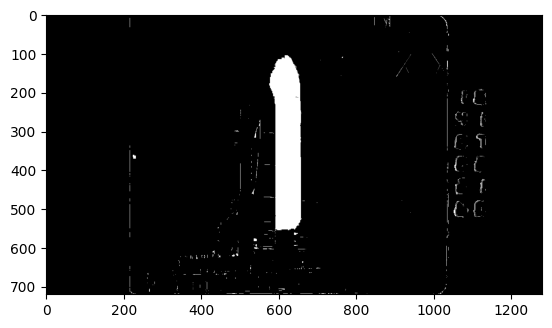

In [21]:
lower_s = 80
upper_s = 220
mask = cv2.inRange(s, lower_s, upper_s)
plt.imshow(mask, cmap='gray');

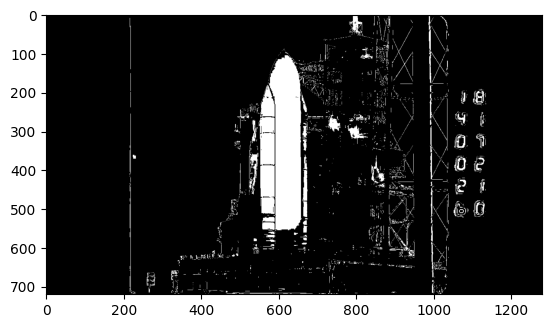

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Zakładając, że masz już obrazy dla kanałów 'v' i 's' (np. w przestrzeni HSV)

# Ustal zakresy dla szarości (na podstawie V) oraz nasycenia (na podstawie S)
lower_gray = 120
upper_gray = 150
lower_s = 80
upper_s = 220

# Tworzymy maski dla szarości (V) i nasycenia (S)
gray_mask = cv2.inRange(v, lower_gray, upper_gray)
saturation_mask = cv2.inRange(s, lower_s, upper_s)

# Łączymy obie maski, zachowując białe piksele z obu
final_mask = cv2.bitwise_or(gray_mask, saturation_mask)

# Wyświetlamy wynik
plt.imshow(final_mask, cmap='gray')
plt.show()


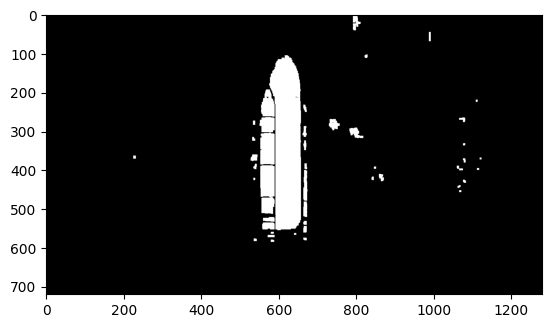

In [69]:
open_mask = cv2.morphologyEx(final_mask, cv2.MORPH_OPEN, np.ones((5,5), np.uint8))
plt.imshow(open_mask, cmap='gray');

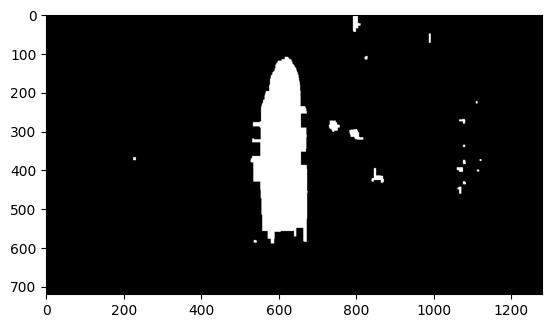

In [71]:
close_mask = cv2.morphologyEx(open_mask, cv2.MORPH_CLOSE, np.ones((8,5), np.uint8), iterations=4)
plt.imshow(close_mask, cmap='gray');

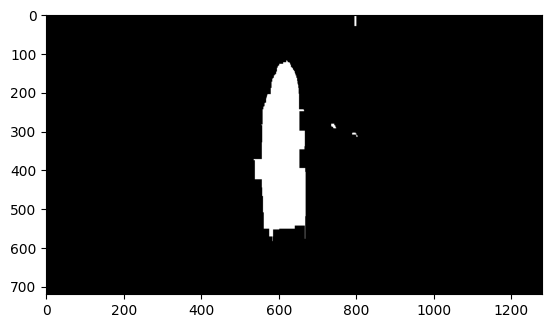

In [73]:
eroded_mask = cv2.erode(close_mask, np.ones((8,5), np.uint8), iterations=2)
plt.imshow(eroded_mask, cmap='gray');

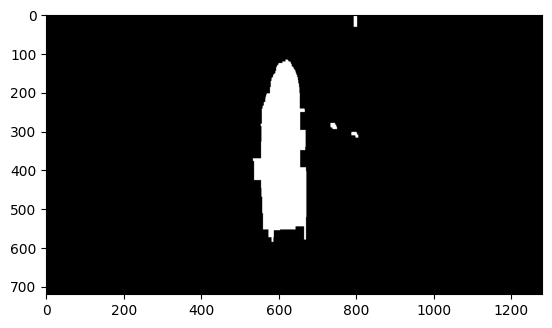

In [74]:
dilate_mask = cv2.dilate(eroded_mask, np.ones((5,5), np.uint8), iterations=1)
plt.imshow(dilate_mask, cmap='gray');

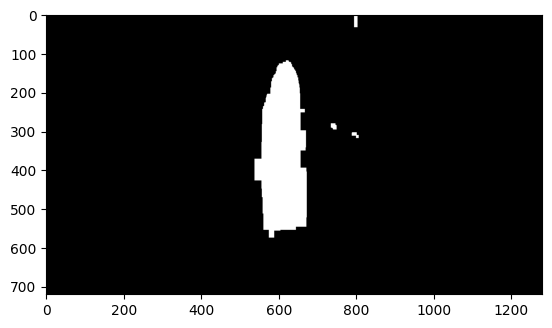

In [75]:
complete_mask = cv2.morphologyEx(dilate_mask, cv2.MORPH_OPEN, np.ones((8,6), np.uint8), iterations=1)
plt.imshow(complete_mask, cmap='gray');

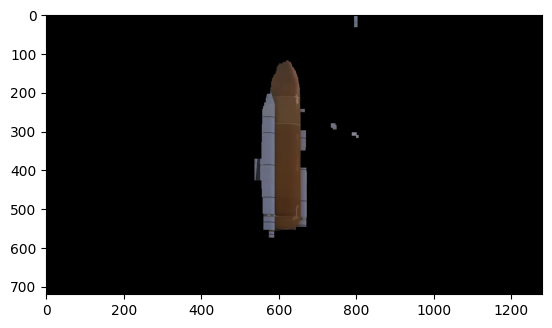

In [76]:
mask_on_source = cv2.bitwise_and(frame, frame, mask=complete_mask)
plt.imshow(mask_on_source[..., ::-1]);

C:\Users\kjani\AppData\Local\Temp\ipykernel_14912\1731924181.py:2: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  features = np.int0(features)


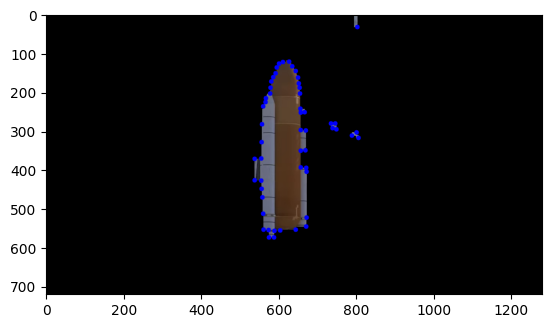

In [77]:
features = cv2.goodFeaturesToTrack(complete_mask, 100, 0.1, 10)
features = np.int0(features)
source_with_points = mask_on_source.copy()

for feature in features:
    x, y = feature.ravel()
    cv2.circle(source_with_points, (x, y), 6, 255, -1)

plt.imshow(source_with_points[..., ::-1]);

C:\Users\kjani\AppData\Local\Temp\ipykernel_14912\121975039.py:2: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  features = np.int0(features)


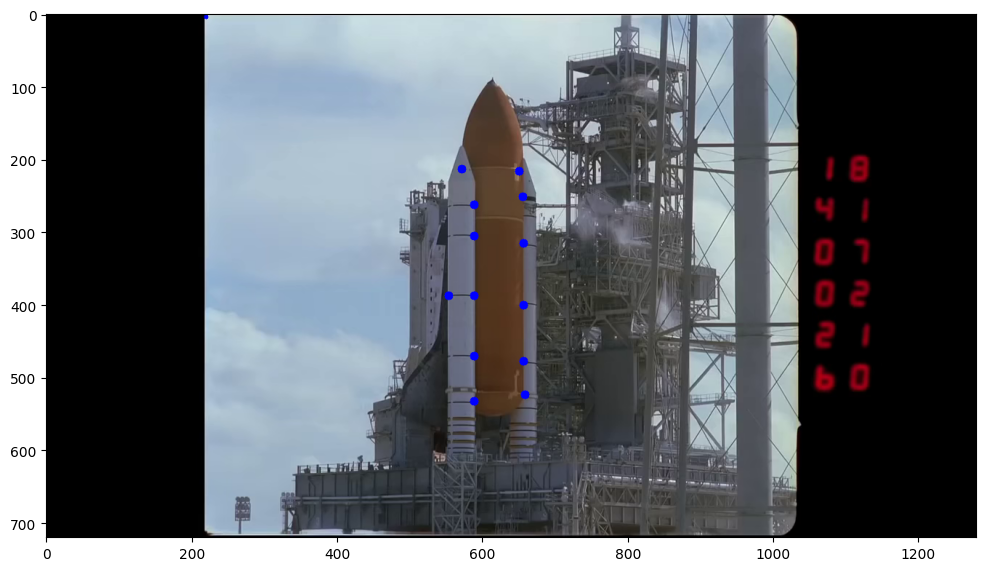

In [78]:
features = cv2.goodFeaturesToTrack(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), 100, 0.1, 30, mask=complete_mask)
features = np.int0(features)
source_with_points = frame.copy()

for feature in features:
    x, y = feature.ravel()
    cv2.circle(source_with_points, (x, y), 6, 255, -1)

plt.figure(figsize=(12,12))
plt.imshow(source_with_points[..., ::-1]);

### Zadanie 2

Uzupełnij daną poniżej podstawową pętlę analizy wideo o śledzenie obiektów: inicjalizację i wykorzystanie przepływu optycznego do aktualizacji ich położenia. Celem jest pozyskanie pełnej trajektorii pojazdu, tak aby można było ją narysować (np. [`cv2.polylines`](https://docs.opencv.org/3.4/d6/d6e/group__imgproc__draw.html#gaa3c25f9fb764b6bef791bf034f6e26f5)) tudzież przetwarzać dalej.

Zapoznaj się dobrze z dokumentacją funkcji [`cv2.calcOpticalFlowPyrLK`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323), zwłaszcza z wartościami zwracanymi, **zwłaszcza** `status`. Upewnij się, że odpowiednio obsługujesz przypadki niepowodzenia znalezienia przepływu dla poszczególnych punktów.

Wynik zaprezentuj w postaci graficznej (narysowane trajektorie).

In [12]:
def baseLoop(source: cv2.VideoCapture):
    frame1 = None
    status, frame2 = source.read()
    frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
    # ...
    # inicjalizacja metody
    # ...
    while status:
        frame1 = frame2
        status, frame2 = source.read()
        frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
        # ...
        # przetwarzanie
        # ...

In [79]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def baseLoopWithPlot(source: cv2.VideoCapture, points):
    status, frame2 = source.read()
    if not status:
        print("Nie udało się odczytać pierwszej klatki.")
        return

    points = np.float32(points)
    frame2_gray = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
    mask = np.zeros_like(frame2)

    # Tworzymy DataFrame do przechowywania trajektorii
    columns = ['frame', 'point_id', 'x', 'y']
    trajectories_df = pd.DataFrame(columns=columns)

    times = []  # Lista czasów w sekundach

    # Pobieramy FPS wideo
    fps = source.get(cv2.CAP_PROP_FPS)
    
    # Indeks klatki i czas w sekundach
    frame_idx = 0
    time_sec = 0  # Czas w sekundach

    while status:
        frame1_gray = frame2_gray
        status, frame2 = source.read()

        if not status:  # Upewnij się, że odczytano kolejną klatkę
            break

        frame2_gray = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

        # Obliczanie przepływu optycznego
        next_points, st, _ = cv2.calcOpticalFlowPyrLK(frame1_gray, frame2_gray, points, None)
        good_new = next_points[st == 1]
        good_old = points[st == 1]

        # Rysowanie trajektorii
        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = map(int, new.ravel())
            c, d = map(int, old.ravel())

            # Dodajemy sprawdzenie czy punkt jest blisko górnej krawędzi
            if b < 15:  # Jeśli punkt jest blisko górnej krawędzi (np. mniej niż 10 pikseli od góry)
                trajectories_df = trajectories_df.append({'frame': frame_idx, 'point_id': i, 'x': None, 'y': None}, ignore_index=True)
                continue

            mask = cv2.line(mask, (c, d), (a, b), (0, 255, 0), 2)  # Linia
            frame2 = cv2.circle(frame2, (a, b), 5, (0, 0, 255), -1)  # Punkt

            # Dodajemy dane do DataFrame
            trajectories_df = trajectories_df.append({'frame': frame_idx, 'point_id': i, 'x': a, 'y': b}, ignore_index=True)

        # Dodanie rzeczywistego czasu (w sekundach) do listy czasów
        times.append(time_sec)

        # Dodanie maski do klatki
        img = cv2.add(frame2, mask)

        # Wyświetlenie wyniku
        cv2.imshow('Trajektorie', img)

        # Aktualizacja punktów do śledzenia
        points = good_new.reshape(-1, 1, 2)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        frame_idx += 1  # Zwiększanie indeksu klatki
        time_sec = frame_idx / fps  # Czas w sekundach na podstawie FPS

    source.release()
    cv2.destroyAllWindows()

    return trajectories_df, times  # Zwracamy także DataFrame i listę czasów w sekundach


In [14]:
trajectories, times = baseLoopWithPlot(cv2.VideoCapture('dane/shuttle.mp4'), features)

C:\Users\kjani\AppData\Local\Temp\ipykernel_13624\2656984478.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trajectories_df = trajectories_df.append({'frame': frame_idx, 'point_id': i, 'x': a, 'y': b}, ignore_index=True)
C:\Users\kjani\AppData\Local\Temp\ipykernel_13624\2656984478.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trajectories_df = trajectories_df.append({'frame': frame_idx, 'point_id': i, 'x': a, 'y': b}, ignore_index=True)
C:\Users\kjani\AppData\Local\Temp\ipykernel_13624\2656984478.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trajectories_df = trajectories_df.append({'frame': frame_idx, 'point_id': i, 'x': a, 'y': b}, ignore_index=True)
C:\Users\kjani\AppData\Local\Temp\ipykernel_13624\26

In [80]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def baseLoopWithPlot(source: cv2.VideoCapture, points):
    status, frame2 = source.read()
    if not status:
        print("Nie udało się odczytać pierwszej klatki.")
        return

    points = np.float32(points)
    frame2_gray = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
    mask = np.zeros_like(frame2)

    times = []  # Lista czasów w sekundach
    fps = source.get(cv2.CAP_PROP_FPS)  # Pobieramy FPS wideo

    # Punkt ID przechowywane w słowniku (dla unikalnych punktów)
    trajectories = {i: [] for i in range(len(points))}  # Słownik do przechowywania trajektorii każdego punktu
    frame_idx = 0
    time_sec = 0  # Czas w sekundach

    while status:
        frame1_gray = frame2_gray
        status, frame2 = source.read()

        if not status:
            break

        frame2_gray = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

        # Obliczanie przepływu optycznego
        next_points, st, _ = cv2.calcOpticalFlowPyrLK(frame1_gray, frame2_gray, points, None)
        good_new = next_points[st == 1]
        good_old = points[st == 1]

        # Rysowanie trajektorii
        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = map(int, new.ravel())
            c, d = map(int, old.ravel())

            # Sprawdzamy, czy punkt znajduje się wystarczająco blisko krawędzi obrazu
            if a < 15 or b < 15 or a > frame2.shape[1] - 15 or b > frame2.shape[0] - 15:
                st[i] = 0  # Przestajemy śledzić punkt, ustawiając jego status na 0
                continue  # Zatrzymujemy dalsze przetwarzanie dla tego punktu

            mask = cv2.line(mask, (c, d), (a, b), (0, 255, 0), 2)
            frame2 = cv2.circle(frame2, (a, b), 5, (0, 0, 255), -1)

            # Dodajemy punkt do odpowiedniej trajektorii
            trajectories[i].append((frame_idx, a, b))

        # Zaktualizowanie punktów dla następnej klatki
        points = good_new.reshape(-1, 1, 2)

        times.append(time_sec)
        img = cv2.add(frame2, mask)
        cv2.imshow('Trajektorie', img)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        frame_idx += 1
        time_sec = frame_idx / fps

    source.release()
    cv2.destroyAllWindows()

    # Przefiltruj trajektorie raz, po zakończeniu śledzenia
    cleaned_trajectories = {}
    for point_id, traj in trajectories.items():
        filtered_traj = []
        last_x, last_y = None, None
        for _, x, y in traj:
            # Filtrowanie na podstawie skoków i wartości (np. poniżej progu)
            if last_x is not None and (abs(x - last_x) > 10 or abs(y - last_y) > 15):
                continue  # Pomijamy skoki większe niż 100 pikseli
            if y < 30:  # Przykład: filtrujemy punkty poniżej 10 pikseli na osi Y
                continue  # Pomijamy punkty poniżej progu
            filtered_traj.append((_, x, y))
            last_x, last_y = x, y

        cleaned_trajectories[point_id] = filtered_traj

    # Rysowanie trajektorii na wykresie
    plt.figure(figsize=(20, 10))
    for point_id, traj in cleaned_trajectories.items():
        if traj:  # Rysujemy tylko, jeśli są dane
            x_vals, y_vals = zip(*[(x, y) for _, x, y in traj])
            plt.plot(x_vals, y_vals, label=f'Traj {point_id}')

    plt.gca().invert_yaxis()  # Odwrócenie osi Y dla lepszej zgodności z obrazem
    plt.title("Trajektorie punktów")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid()
    plt.show()

    return cleaned_trajectories, times


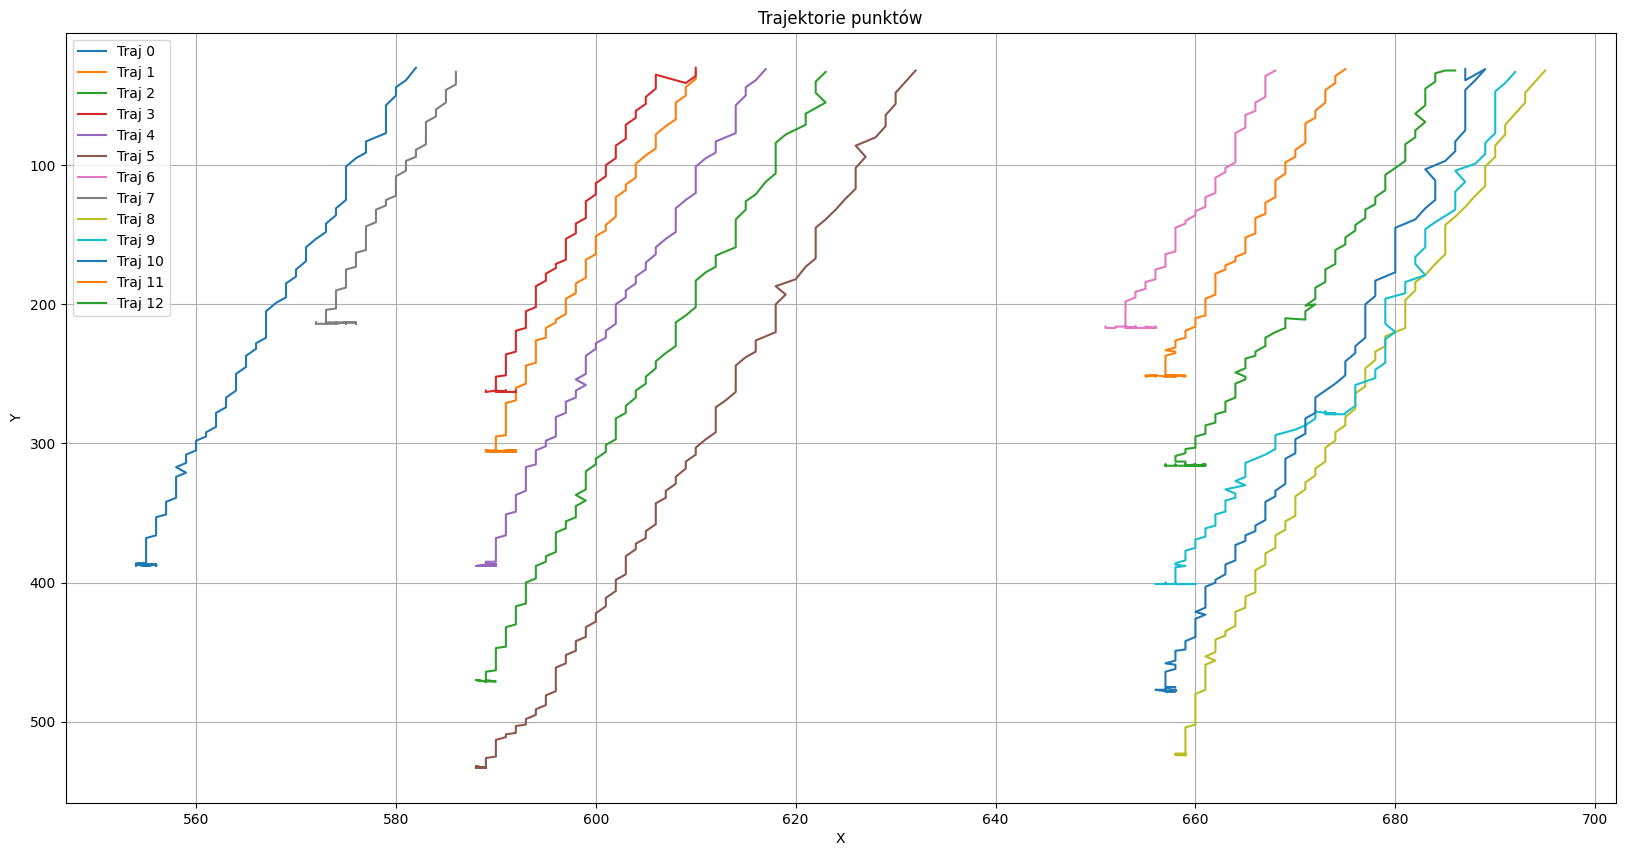

In [81]:
trajectories, times = baseLoopWithPlot(cv2.VideoCapture('dane/shuttle.mp4'), features)

### Zadanie 3

Dokonaj analizy znalezionych trajektorii i znajdź prędkość _Discovery_.

Wersja minimum: załóż, że pojazd porusza się z lokalnie stałą prędkością.  
Wersja normalna: wykreśl prędkość pojazdu jako funkcję czasu.  
Wersja z plusem: zastosuj odpowiednią filtrację funkcji położenia, by uniezależnić funkcję czasu od szumu.

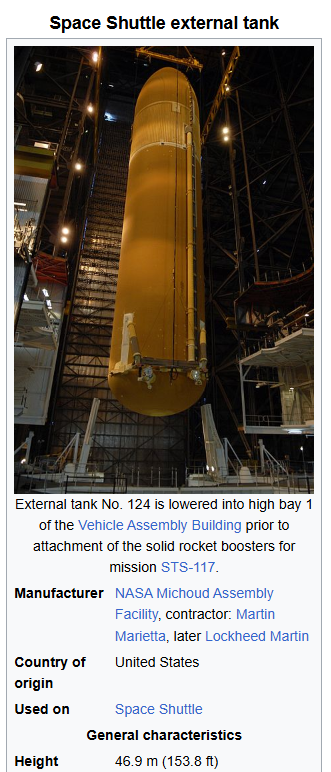

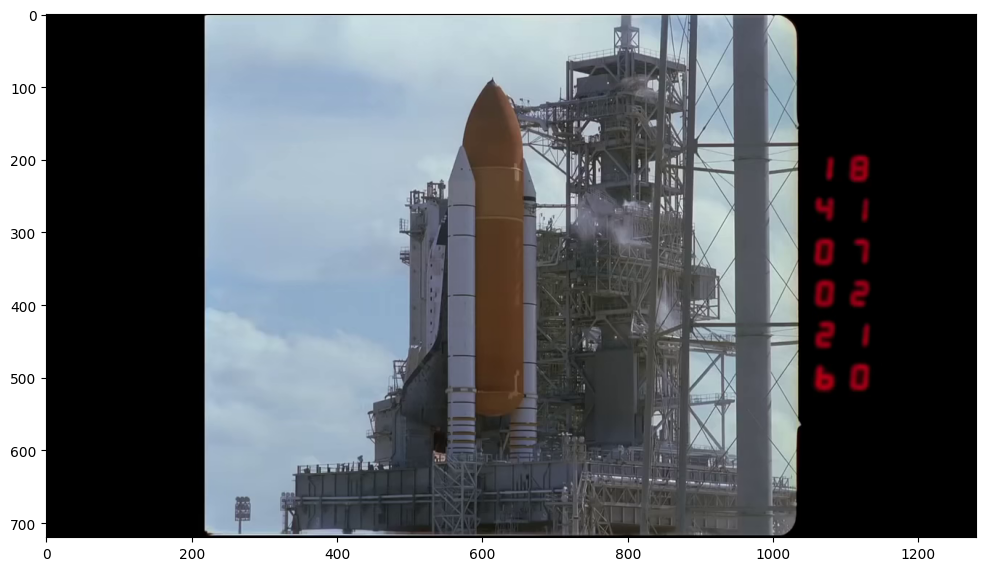

In [82]:
source = cv2.VideoCapture('dane/shuttle.mp4')
status, frame = source.read()
source.release()
plt.subplots(1, 1, figsize=(12,12))[1].imshow(frame[..., ::-1]);

In [83]:
import cv2
import time

# Wczytanie wideo
cap = cv2.VideoCapture('dane/shuttle.mp4')

# Sprawdzenie, czy wideo zostało poprawnie wczytane
if not cap.isOpened():
    print("Nie udało się otworzyć wideo.")
    exit()

# Pobranie liczby klatek na sekundę (fps)
fps = cap.get(cv2.CAP_PROP_FPS)

# Pętla odtwarzania wideo
while True:
    ret, frame = cap.read()
    
    # Jeśli nie udało się wczytać klatki (koniec wideo)
    if not ret:
        break
    
    # Obliczanie czasu (sekundy) od początku wideo
    current_time = cap.get(cv2.CAP_PROP_POS_MSEC) / 1000  # Czas w sekundach
    
    # Wyświetlanie czasu na wideo
    time_text = f"Time: {current_time:.2f} s"
    cv2.putText(frame, time_text, (20, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    
    # Wyświetlenie klatki
    cv2.imshow('Odtwarzanie wideo', frame)
    
    # Przerwanie odtwarzania po naciśnięciu klawisza 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Zwolnienie zasobów i zamknięcie okna
cap.release()
cv2.destroyAllWindows()


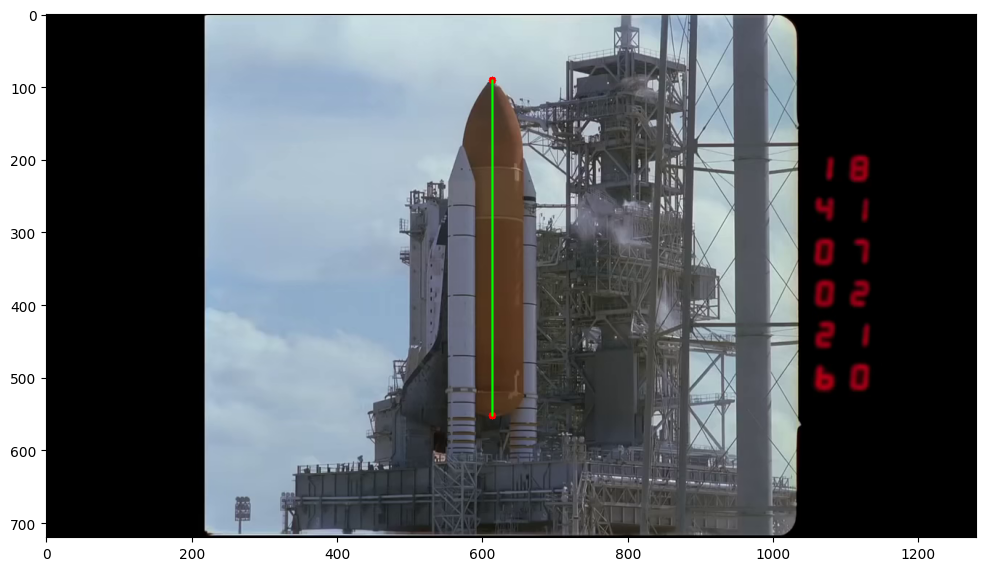

In [84]:
points = [(614, 92), (614, 553)]
#frame from video
source = cv2.VideoCapture('dane/shuttle.mp4')
status, frame = source.read()
#line between points
frame_with_points = frame.copy()
for point in points:
    cv2.circle(frame_with_points, point, 5, (0, 0, 255), -1)
cv2.line(frame_with_points, points[0], points[1], (0, 255, 0), 2)
plt.figure(figsize=(12, 12))
plt.imshow(frame_with_points[..., ::-1]);

In [85]:
import numpy as np

def get_scaling_factor_from_points(distance_m=46.9):
    point1, point2 = (614, 92), (614, 553)
    distance_px = point2[1] - point1[1]
    scaling_factor = distance_m / distance_px
    print(f"Przelicznik skalowania: {scaling_factor:.5f} metra na piksel.")
    return scaling_factor

In [86]:
scaling_factor = get_scaling_factor_from_points()

Przelicznik skalowania: 0.10174 metra na piksel.


In [87]:
def baseLoopWithPlot(source: cv2.VideoCapture, points):
    status, frame2 = source.read()
    if not status:
        print("Nie udało się odczytać pierwszej klatki.")
        return

    points = np.float32(points)
    frame2_gray = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
    mask = np.zeros_like(frame2)

    times = []  # Lista czasów w sekundach
    fps = source.get(cv2.CAP_PROP_FPS)  # Pobieramy FPS wideo

    trajectories = {i: [] for i in range(len(points))}  # Słownik do przechowywania trajektorii każdego punktu
    frame_idx = 0
    time_sec = 0  # Czas w sekundach

    while status:
        frame1_gray = frame2_gray
        status, frame2 = source.read()

        if not status:
            break

        frame2_gray = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

        # Obliczanie przepływu optycznego
        next_points, st, _ = cv2.calcOpticalFlowPyrLK(frame1_gray, frame2_gray, points, None)
        good_new = next_points[st == 1]
        good_old = points[st == 1]

        # Rysowanie trajektorii
        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = map(int, new.ravel())
            c, d = map(int, old.ravel())

            # Sprawdzamy, czy punkt znajduje się wystarczająco blisko krawędzi obrazu
            if a < 20 or b < 20 or a > frame2.shape[1] - 20 or b > frame2.shape[0] - 20:
                st[i] = 0  # Przestajemy śledzić punkt, ustawiając jego status na 0
                continue  # Zatrzymujemy dalsze przetwarzanie dla tego punktu

            mask = cv2.line(mask, (c, d), (a, b), (0, 255, 0), 2)
            frame2 = cv2.circle(frame2, (a, b), 5, (0, 0, 255), -1)

            # Dodajemy punkt do odpowiedniej trajektorii
            trajectories[i].append((frame_idx, a, b))

        # Zaktualizowanie punktów dla następnej klatki
        points = good_new.reshape(-1, 1, 2)

        times.append(time_sec)
        img = cv2.add(frame2, mask)
        cv2.imshow('Trajektorie', img)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        frame_idx += 1
        time_sec = frame_idx / fps

    source.release()
    cv2.destroyAllWindows()

    # Obliczanie prędkości
    all_speeds = []  # Lista wszystkich prędkości w czasie
    for i in range(len(trajectories[0])):  # Iteracja przez wszystkie klatki
        frame_speeds = []  # Prędkości w tej klatce dla wszystkich punktów
        for point_id, traj in trajectories.items():
            if i > 0 and i < len(traj):
                t1, x1, y1 = traj[i-1]
                t2, x2, y2 = traj[i]
                distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
                time_diff = (t2 - t1) / fps
                speed = distance / time_diff
                frame_speeds.append(speed)
        
        if frame_speeds:  # Jeśli są prędkości w tej klatce
            all_speeds.append(np.mean(frame_speeds)*scaling_factor)  # Średnia prędkość w tej klatce

    # Rysowanie wykresu średniej prędkości
    plt.figure(figsize=(20, 10))
    plt.plot(times[1:][:len(all_speeds)], all_speeds, label='Średnia prędkość')
    plt.title("Średnia prędkość punktów w czasie")
    plt.xlabel("Czas (s)")
    plt.ylabel("Średnia prędkość (m/s)")
    plt.legend()
    plt.grid()
    plt.show()


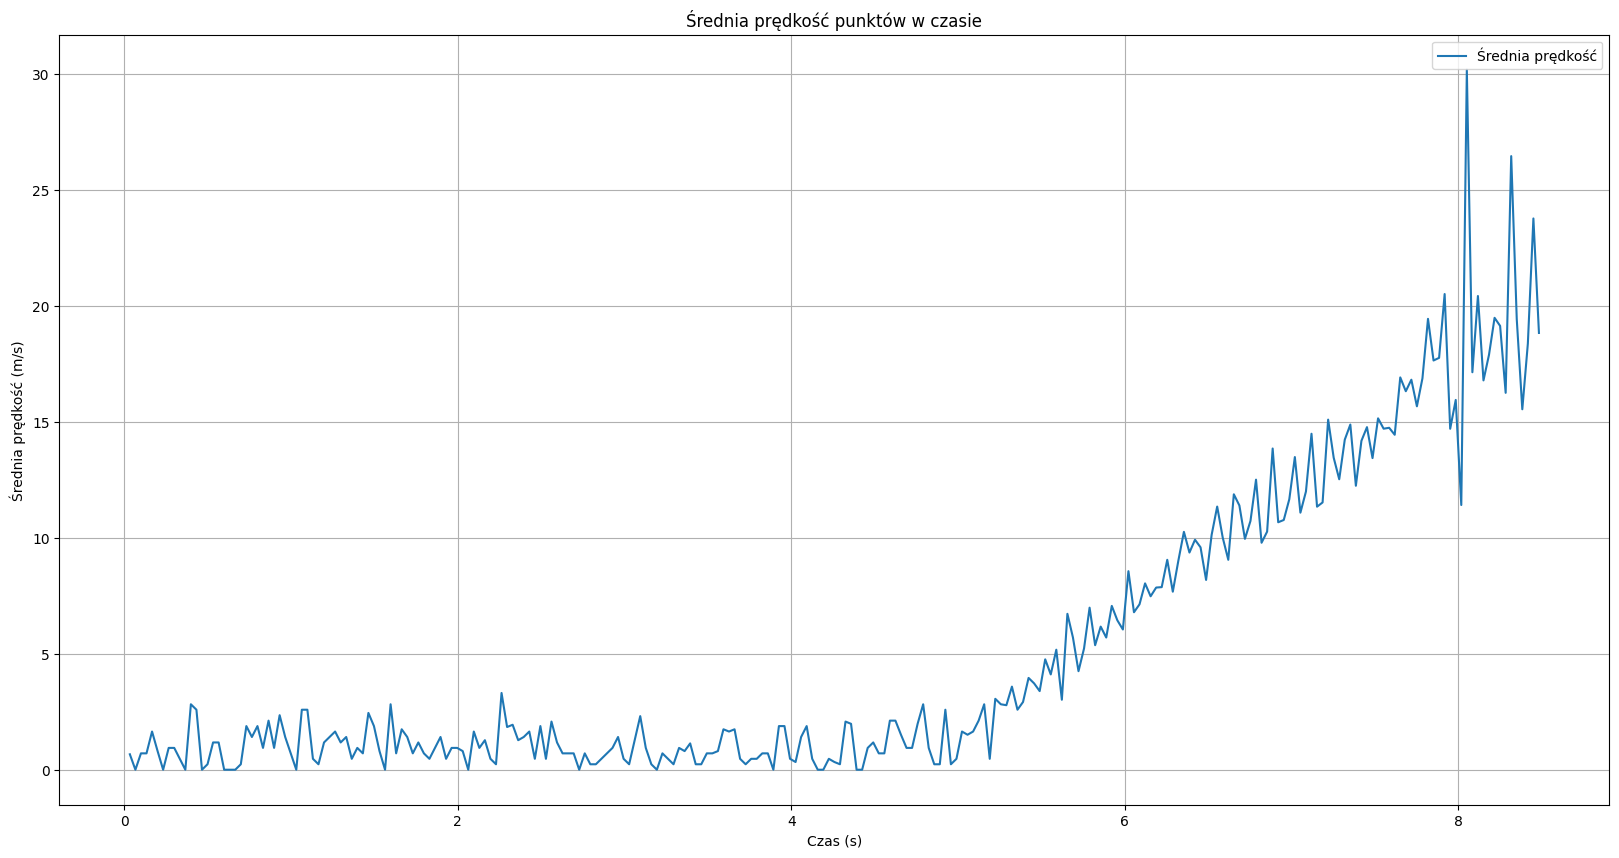

In [88]:
baseLoopWithPlot(cv2.VideoCapture('dane/shuttle.mp4'), features)

In [157]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def baseLoopWithPlot(source: cv2.VideoCapture, points, alpha=0.1, beta=0.1):
    # Inicjalizacja zmiennej frame_idx
    frame_idx = 0  # Początkowy indeks klatki

    status, frame2 = source.read()
    if not status:
        print("Nie udało się odczytać pierwszej klatki.")
        return

    points = np.float32(points)
    frame2_gray = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
    mask = np.zeros_like(frame2)

    times = []  # Lista czasów w sekundach
    fps = source.get(cv2.CAP_PROP_FPS)  # Pobieramy FPS wideo

    # Inicjalizacja filtrów alfa-beta dla pozycji i prędkości
    predicted_positions = np.copy(points)  # Początkowe przewidywane pozycje
    velocities = np.zeros_like(points)  # Początkowe prędkości

    trajectory_x = []  # Lista pozycji wzdłuż osi X
    avg_velocity_values = []  # Lista średnich prędkości w klatkach

    while status:
        frame1_gray = frame2_gray
        status, frame2 = source.read()

        if not status:
            break

        frame2_gray = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

        # Obliczanie przepływu optycznego
        next_points, st, _ = cv2.calcOpticalFlowPyrLK(frame1_gray, frame2_gray, points, None)
        good_new = next_points[st == 1]
        good_old = points[st == 1]

        # Rysowanie trajektorii i aktualizacja filtrów alfa-beta
        frame_speeds = []  # Lista prędkości w tej klatce

        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = map(int, new.ravel())
            c, d = map(int, old.ravel())
            if b < 30 or b > frame2.shape[0] - 30:
                st[i] = 0
                continue

            # Estymacja pozycji i prędkości z filtra alfa-beta
            predicted_positions[i] = predicted_positions[i] + velocities[i]
            position_error = np.array([a, b]) - predicted_positions[i]

            # Aktualizacja pozycji i prędkości na podstawie błędu
            velocities[i] = velocities[i] + beta * position_error
            predicted_positions[i] = predicted_positions[i] + alpha * position_error

            # Obliczanie prędkości punktu
            velocity = np.linalg.norm(velocities[i])
            frame_speeds.append(velocity)

            # Dodajemy dane do wykresu
            trajectory_x.append(a)  # Pozycja wzdłuż osi X

        # Obliczanie średniej prędkości w tej klatce (średnia prędkość wszystkich punktów)
        if frame_speeds:
            avg_velocity = np.mean(frame_speeds)  # Średnia prędkość w klatce
            avg_velocity_values.append(avg_velocity)  # Dodajemy ją do listy

        # Zaktualizowanie punktów dla następnej klatki
        points = good_new.reshape(-1, 1, 2)

        # Dodawanie czasu
        times.append(frame_idx / fps)
        frame_idx += 1

    source.release()
    cv2.destroyAllWindows()

    # Rysowanie wykresu średniej prędkości względem czasu
    plt.figure(figsize=(10, 6))
    plt.plot(times[:len(avg_velocity_values)], avg_velocity_values, color='blue', label='Średnia prędkość')
    plt.title("Średnia prędkość w czasie (Filtr Alfa-Beta)")
    plt.xlabel("Czas (sekundy)")
    plt.ylabel("Średnia prędkość (piksele/sekundę)")
    plt.legend()
    plt.grid(True)
    plt.show()


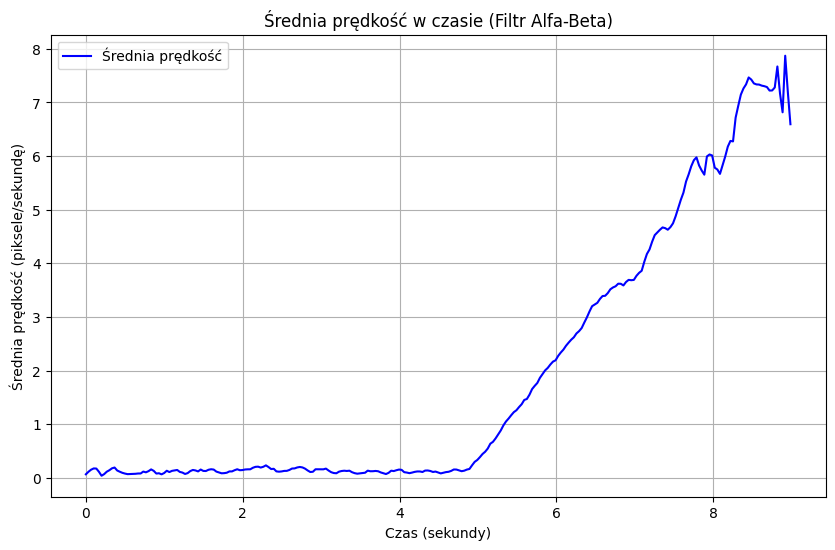

In [158]:
baseLoopWithPlot(cv2.VideoCapture('dane/shuttle.mp4'), features)